## RAG Agent



In [ ]:
#| default_exp examples.rag

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

True

In [ ]:
#| export
from stringdale import V,E,Define
from stringdale.chat import Chat
from stringdale.db import ChromaClient

In [ ]:
chroma_client = ChromaClient()

In [ ]:
dog_docs = [
    {
        'id': 'dog1',
        'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
        'metadata': {'breed': 'Golden Retriever'}
    },
    {
        'id': 'dog2', 
        'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.',
        'metadata': {'breed': 'German Shepherd'}
    },
    {
        'id': 'dog3',
        'text': 'The Golden Retriever is a friendly, intelligent breed with a beautiful golden coat. They are wonderful family pets that get along well with kids.',
        'metadata': {'breed': 'Golden Retriever'}  # Near duplicate of dog1
    },
    {
        'id': 'dog4',
        'text': 'Huskies are energetic working dogs bred for cold climates. They have thick fur and often blue eyes.',
        'metadata': {'breed': 'Husky'}
    },
    {
        'id': 'dog5',
        'text': 'Siberian Huskies are active working dogs that thrive in cold weather. They are known for their thick coats and striking blue eyes.',
        'metadata': {'breed': 'Husky'}  # Near duplicate of dog4
    }
]

# Add documents to index
chroma_client.add_collection("dog_docs",exists_ok=True)
chroma_client.upsert(collection_name="dog_docs",docs=dog_docs)

[{'id': 'dog1',
  'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
  'metadata': {'breed': 'Golden Retriever'}},
 {'id': 'dog2',
  'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.',
  'metadata': {'breed': 'German Shepherd'}},
 {'id': 'dog3',
  'text': 'The Golden Retriever is a friendly, intelligent breed with a beautiful golden coat. They are wonderful family pets that get along well with kids.',
  'metadata': {'breed': 'Golden Retriever'}},
 {'id': 'dog4',
  'text': 'Huskies are energetic working dogs bred for cold climates. They have thick fur and often blue eyes.',
  'metadata': {'breed': 'Husky'}},
 {'id': 'dog5',
  'text': 'Siberian Huskies are active working dogs that thrive in cold weather. They are known for their thick coats and striking blue eyes.',
  'metadata': {'breed': 'Husky'}}]

In [ ]:
#| export
def RagFactory(db:ChromaClient,collection_name:str,k:int,model:str='gpt-4o-mini',system_prompt:str=None):
    """
    A diagram Factory for a RAG workflow.

    Args:
        db: A ChromaClient instance.
        collection_name: The name of the collection to use.
        k: The number of documents to retrieve.
        system_prompt: A system prompt to use for the RAG workflow.
            make sure to include references to the documents in the system prompt.
            documents are fed to the prompt under the key 'docs' 
            which is a list of dictionaries whose 'text' key is the document text.
    
    Returns:
        A Rag diagram schema.
    """
    if system_prompt is None:
        system_prompt = '''
            You are a helpful assistant that answers questions about dogs.
            I found the following documents that may be relevant to the user's question:
            {% for doc in docs %}
            {{doc['text']}}
            {% endfor %}
            '''
    rag_chat = Chat(model=model,messages=[
        {'role':'system','content':system_prompt},
        {'role':'user','content':'{{question}}'},
        ])

    def db_query(query:str):
        return db.query(collection_name=collection_name,k=k,query=query)
    
    with Define('RAG Agent',type='flow') as RagSchema:
        V('get_docs',db_query,
            inputs=['Start(**)'],
        )
        V('chat',rag_chat,
            inputs=['get_docs(docs)','Start(question=query)'],
            outputs=['End']
        )
    return RagSchema

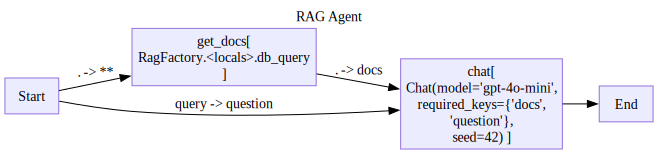

In [ ]:
D = RagFactory(db=chroma_client,collection_name='dog_docs',k=2)
D.draw()

In [ ]:
d=D()
for trace in d.run({'query':'tell me some stuff about golden retrievers'}):
    trace.pprint()

d.output


---
name: Start
input:
  query: tell me some stuff about golden retrievers
output:
  query: tell me some stuff about golden retrievers
---
name: get_docs
input:
  query: tell me some stuff about golden retrievers
output:
- id: dog3
  text: The Golden Retriever is a friendly, intelligent breed with a beautiful golden
    coat. They are wonderful family pets that get along well with kids.
  metadata:
    breed: Golden Retriever
  distance: 0.6992775201797485
- id: dog1
  text: The Golden Retriever is a friendly, intelligent breed known for its golden
    coat. They make excellent family pets and are great with children.
  metadata:
    breed: Golden Retriever
  distance: 0.7122190594673157
---
name: chat
input:
  question: tell me some stuff about golden retrievers
  docs:
  - id: dog3
    text: The Golden Retriever is a friendly, intelligent breed with a beautiful golden
      coat. They are wonderful family pets that get along well with kids.
    metadata:
      breed: Golden Retriever

{'role': 'assistant',
 'content': 'Golden Retrievers are a popular dog breed known for their friendly and intelligent nature. Here are some key points about them:\n\n1. **Temperament**: Golden Retrievers are known for their friendly and gentle demeanor. They are highly sociable and get along well with children and other pets, making them excellent family dogs.\n\n2. **Intelligence**: This breed is highly intelligent and eager to please, which makes them easy to train. They excel in obedience training and are often used as service dogs due to their ability to learn commands quickly.\n\n3. **Physical Characteristics**: Golden Retrievers have a distinctive golden coat that is water-repellent, aiding in outdoor activities. Their fur can vary in shade from light to dark golden.\n\n4. **Exercise Needs**: They are active and energetic dogs that require regular exercise. Daily walks, playtime, and mental stimulation are essential to keep them healthy and happy.\n\n5. **Health Considerations**:

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()